# Inference using Bayesian Networks

Inference is a powerful technique that combines empirical evidence and prior statistical beliefs to determine likelihood from causal connections. A classic example is presented below in graphical form (taken from [this blog](https://towardsdatascience.com/introduction-to-bayesian-networks-81031eeed94e); please excuse the convention of substituting commas for decimal places):

![wet grass example](https://miro.medium.com/max/1385/1*9OsQV0PqM2juaOtGqoRISw.jpeg)

As shown above, there are two causal explanations for why the grass is wet-- the sprinkler could be on, or it could have rained. We can enter the graph at any point to infer the conditional likelihood of each variable; for example, if we know the state of *cloudy*, we can replace the 50/50 prior probability, and propagate that through the graph. We can also reverse the direction; if we know that the grass is wet, we can infer the empirical likelihood of *cloudy* being true such that it is weighted by this evidence, instead of just the prior belief. Note that this means that it is possible to determine prior beliefs from data, by choosing an naive prior and replacing after acquiring empirical data.

The classical example above maps to ICESat-2 data with some simple modifications. Let's sat that you observe an ICESat-2 QAQC flag that the data is "not useful", caused by the ATL06 algorithm failing to find the ground. There are several possible causal reasons for this: the surface could be obscured by optically thick clouds; the surface could be complex because of crevassing; there could blowing snow on the surface; there could be an instrument issue. If we discount the last option of instrumentation error, we can pull out useful information from the QAQC flag about the physical process that is causing the flag. If we have cloud data (i.e., from another data source like VIIRS), or wind data, we can start to build a statistical inference pipeline that will infer the likelihood of blowing snow or crevasses.

### Numeric Considerations

Bayesian nets can be used as simple feed forward networks (if we are confident in our priors), or trained to determine the conditional probabilities that the network itself uses. We'll use pymc3 in this notebook to examine how to formulate and build Bayesian networks-- first using discrete variables, then expanding to incorporate continuous variables. All of this falls under ***probabilistic programming***; there a wide variety of tasks that the framework can be used for. The pymc3 library uses Monte Carlo simulations for inference, which can sped up substantially by GPUs-- although they run just fine on CPUs as well.

## Defining a Probabilistic Model

We'll use a worked epidemiology example to show how to set both static parameters, and distributions over parameters, and then explore adding in empirical observations to the model.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import Image
from IPython.display import Markdown as md

In [3]:
import pymc3 as pm
from pymc3 import Normal, Model
from pymc3.math import switch

/srv/conda/envs/MLenv/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


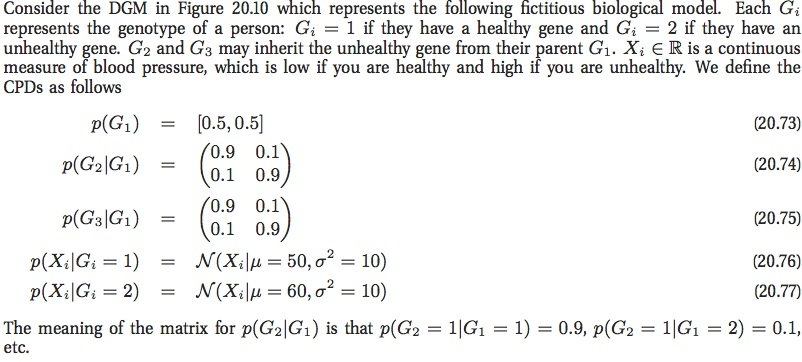

In [4]:
Image('./a4Murphy1.jpg')

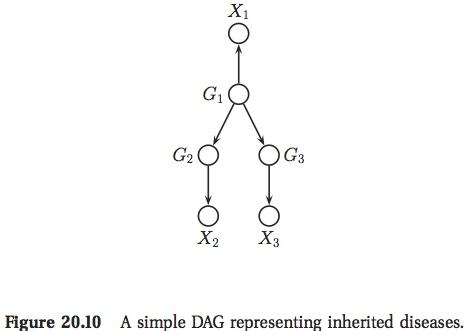

In [5]:
# General model
Image('./a4Murphy2.jpg')

In [6]:
with Model() as bayesnet:
    # Parent
    g1_healthy = pm.distributions.discrete.Bernoulli('g1',0.5)
    
    # Latent variable that conditions the children 
    g1_L = switch(g1_healthy > 0.5, 0.9, 0.1)
    
    # Left Child
    g2_healthy = pm.distributions.discrete.Bernoulli('g2', g1_L)
    # Right Child
    g3_healthy = pm.distributions.discrete.Bernoulli('g3', g1_L)
    # Conditional switches for blood pressure mean
    rate1 = switch(g1_healthy > .5, 50, 60)
    rate2 = switch(g2_healthy > .5, 50, 60)
    rate3 = switch(g3_healthy > .5, 50, 60)
    # Parent and children
    x1 = Normal('x1', mu=rate1, sd=10**.5)
    x2 = Normal('x2', mu=rate2, sd=10**.5)
    x3 = Normal('x3', mu=rate3, sd=10**.5)

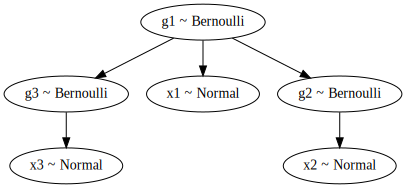

In [7]:
pm.model_graph.model_to_graphviz(model=bayesnet)

We see that the defined model is identical to the reference figure, just with **$X_1$** being placed in below rather than above. The *'G'* parameters are all Bernoulli distributions that specify a binary outcome. The *'$X_*$'* variables are continuous distributions of blood pressure.

## Exercise 1

Compute P(G1 = 2 | X2 = 50). This is the probability that the parent (**$G_1$**) has the heredity disease given that the child (**$X_2$**) has blood pressure of 50.

In [8]:
# Compute P(G1 = 2 | X2 = 50)

with Model() as bayesnet:
    # Parent
    g1_healthy = pm.distributions.discrete.Bernoulli('g1',0.5)
    
    # Latent variable that conditions the children 
    g1_L = switch(g1_healthy > 0.5, 0.9, 0.1)
    
    # Left Child
    g2_healthy = pm.distributions.discrete.Bernoulli('g2', g1_L)
    # Right Child
    g3_healthy = pm.distributions.discrete.Bernoulli('g3', g1_L)
    # Conditional switches for blood pressure mean
    rate1 = switch(g1_healthy > .5, 50, 60)
    rate2 = switch(g2_healthy > .5, 50, 60)
    rate3 = switch(g3_healthy > .5, 50, 60)
    # Grandkids and child
    x1 = Normal('x1', mu=rate1, sd=10**.5)
    # Setting x2 as an observed variable
    x2 = Normal('x2', mu=rate2, sd=10**.5, observed=50)
    x3 = Normal('x3', mu=rate3, sd=10**.5)

Note that the above is identical to our original model definition-- the only thing that has changed, is that we have set **$X_2$** as an observed variable. There is an analytic solution to this type of inference, but we'll use sampling to estimate an empirical solution:

In [9]:
with bayesnet:
    mytrace = pm.sample(10000, tune=2000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [g1, g2, g3]
>NUTS: [x3, x1]
Sampling 4 chains, 0 divergences: 100%|██████████| 48000/48000 [04:05<00:00, 195.13draws/s]
The number of effective samples is smaller than 10% for some parameters.


We see that PyMC3 does the hard work of choosing the appropriate samplers for us :-) The binary variables use Gibbs Metropolis-Hastings, and the continuous use the No-U-Turn-Sampler. The variable **$X_2$** is not sampled, since we set it as observed. The result of the sampling is a *trace*; we can view the trace to get our answer to the original question (although it will take a second to plot given the sample size):

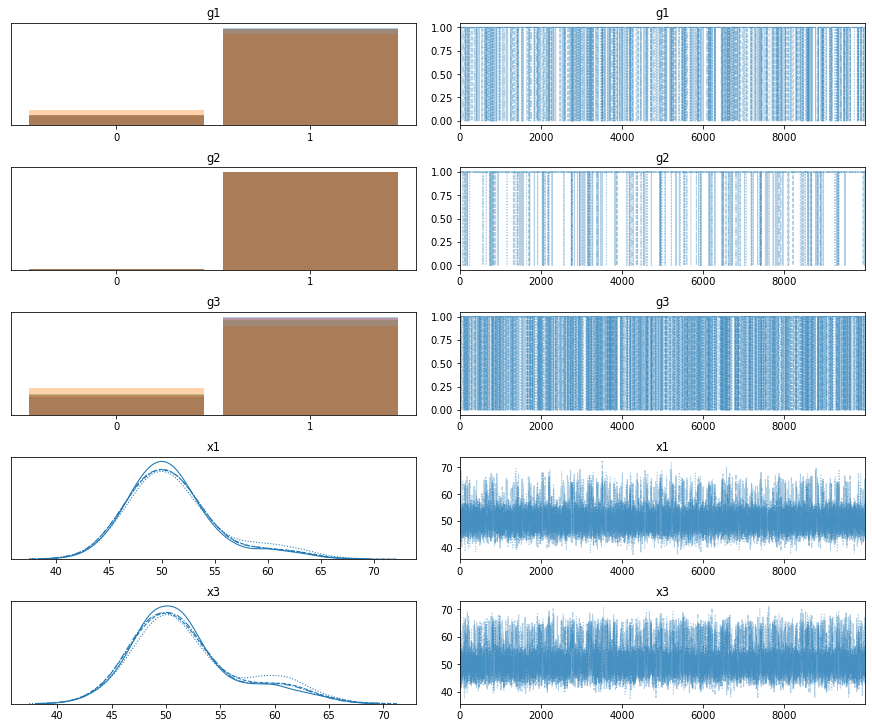

In [10]:
pm.traceplot(mytrace);

The original question was "*what's the probability that the parent has the disease*", so we can take the number of samples where **$G_1 = 1$** (is healthy), and divide by the total number of samples to get the percentage of the population in the simulation that was healthy: 

In [11]:
p_g1_healthy = sum(mytrace['g1'])/len(mytrace['g1'])
p_g1_not_healthy = 1 - p_g1_healthy
p_g1_healthy, p_g1_not_healthy

(0.893325, 0.10667499999999996)

In [12]:
md("""We find {}% of the G1 samples are healthy (G1 = 1); so  {}% are unhealthy (G1 = 2). 
   We can actually access the same information using the `summary()` function, which will also 
   provide an error estimate:""".format(p_g1_healthy.round(4)*100,p_g1_not_healthy.round(4)*100))

We find 89.33% of the G1 samples are healthy (G1 = 1); so  10.67% are unhealthy (G1 = 2). 
   We can actually access the same information using the `summary()` function, which will also 
   provide an error estimate:

In [13]:
pm.summary(mytrace, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
g1,0.89332,0.30870,0.00000,1.00000,0.00761,0.00538,1647.12675,1647.12675,1647.12675,1647.12675,1.00588
g2,0.99218,0.08811,1.00000,1.00000,0.00069,0.00049,16090.00603,16090.00603,16090.00603,40000.00000,1.00008
g3,0.81540,0.38798,0.00000,1.00000,0.00903,0.00639,1846.68906,1846.68906,1846.68906,1846.68906,1.00630
x1,51.09243,4.44766,43.55519,60.89222,0.08253,0.06028,2904.40952,2722.81419,4115.48051,3419.79878,1.00221
x3,51.85390,5.00411,43.97496,62.68362,0.09775,0.07059,2620.91546,2513.53192,3458.31141,6216.06436,1.00305


In [14]:
stats = pm.summary(mytrace, 'g1', round_to=5)
err = round(float(stats.mcse_mean),5)
plus = round(float(1-stats['mean'] + stats.mcse_mean),5)
minus = round(float(1-stats['mean'] - stats.mcse_mean),5)
ans = round(float(1-stats['mean']),5)

md("""As mentioned, we could analytically compute the answer:

- The analytic answer is 0.10535
- The MCMC estimate is {} +/- {}

Since 0.10535 is between {} and {}, seems that we did well.""".format(ans,err,plus,minus))

As mentioned, we could analytically compute the answer:

- The analytic answer is 0.10535
- The MCMC estimate is 0.10668 +/- 0.00761

Since 0.10535 is between 0.11429 and 0.09907, seems that we did well.

Brief digression on MCMC error
---------------

I was curious about the MCMC error... does the sampler actually know how good a job it's doing? Running the sampler again with a factor less samples certainly gives a worse estimate:

In [15]:
with bayesnet:
    mytrace = pm.sample(2000);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [g1, g2, g3]
>NUTS: [x3, x1]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:24<00:00, 400.49draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [16]:
p_g1_healthy = sum(mytrace['g1'])/len(mytrace['g1'])
p_g1_not_healthy = 1 - p_g1_healthy
p_g1_healthy, p_g1_not_healthy

(0.880625, 0.11937500000000001)

In [17]:
pm.summary(mytrace, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
g1,0.88062,0.32425,0.00000,1.00000,0.01734,0.01227,349.79473,349.79473,349.79473,349.79473,1.00694
g2,0.99450,0.07396,1.00000,1.00000,0.00094,0.00067,6144.51864,6144.51864,6144.51864,8000.00000,1.00028
g3,0.78875,0.40822,0.00000,1.00000,0.02125,0.01504,369.11995,369.11995,369.11995,369.11995,1.00705
x1,51.16394,4.47708,43.76447,61.16656,0.18439,0.13429,589.53421,556.29684,809.87079,775.15617,1.00335
x3,52.13296,5.13962,44.55922,63.11791,0.22530,0.16210,520.40437,503.25999,687.08104,1923.05471,1.00384


In [18]:
stats = pm.summary(mytrace, 'g1', round_to=5)
err = round(float(stats.mcse_mean),5)
plus = round(float(1-stats['mean'] + stats.mcse_mean),5)
minus = round(float(1-stats['mean'] - stats.mcse_mean),5)
ans = round(float(1-stats['mean']),5)

md("""The new answer is {} +/- {}. Given that the analytic answer is 0.10535, this 
   is clearly a worse estimate... but 0.10535 still falls within the {} to {} bounded 
   error envelope, so we know the answer is less precise. If we need more precision, we can 
   simply run more samples till the MC error is acceptably low.""".format(ans,err,minus,plus))

The new answer is 0.11938 +/- 0.01734. Given that the analytic answer is 0.10535, this 
   is clearly a worse estimate... but 0.10535 still falls within the 0.10204 to 0.13672 bounded 
   error envelope, so we know the answer is less precise. If we need more precision, we can 
   simply run more samples till the MC error is acceptably low.

## Exercise 2

Compute P(X3  = 50 | X2 = 50). That is, what is the conditional probability that child 2 (**$X_3$**) has blood pressure equal to 50 given that their sibling (child 1, **$X_2$**) has normal blood pressure (50). As before, we simply fix the variable of interest using the observed flag:

In [19]:
with Model() as bayesnet:
    # Parent
    g1_healthy = pm.distributions.discrete.Bernoulli('g1',0.5)
    
    # Latent variable that conditions the children 
    g1_L = switch(g1_healthy > 0.5, 0.9, 0.1)
    
    # Left Child
    g2_healthy = pm.distributions.discrete.Bernoulli('g2', g1_L)
    # Right Child
    g3_healthy = pm.distributions.discrete.Bernoulli('g3', g1_L)
    # Conditional switches for blood pressure mean
    rate1 = switch(g1_healthy > .5, 50, 60)
    rate2 = switch(g2_healthy > .5, 50, 60)
    rate3 = switch(g3_healthy > .5, 50, 60)
    # Grandkids and child
    x1 = Normal('x1', mu=rate1, sd=10**.5)
    x2 = Normal('x2', mu=rate2, sd=10**.5)
    # Setting x3 as an observed variable
    x3 = Normal('x3', mu=rate3, sd=10**.5, observed=50)

In [20]:
with bayesnet:
    mytrace = pm.sample(25000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [g1, g2, g3]
>NUTS: [x2, x1]
Sampling 4 chains, 0 divergences: 100%|██████████| 102000/102000 [04:21<00:00, 390.00draws/s]
The acceptance probability does not match the target. It is 0.8879690375868736, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


Because the variable that we're interested in is continuous, it isn't as obvious how to answer our question... we could of course cheat, and cast *$X_2$* as discrete value:

In [21]:
n1 = mytrace['x2']>51
n2 = mytrace['x2']<50

(len(mytrace['x2']) - sum(n1) - sum(n2))/len(mytrace['x2'])

0.09736

The analytic solution is 0.10306, so casting **$X_2$** as a discrete variable gives a close approximation, but is also kinda unsatisfying because:

- The width for the approximation isn't always obvious. Here, for blood pressure, using a natural number is a pretty clear fit-- but this isn't as obvious for other cases.

- We don't have an error estimation on the approximation. This seems not very Bayesian.

We could also try to cheat an answer by reading **$X_2$** directly off of the trace plots:

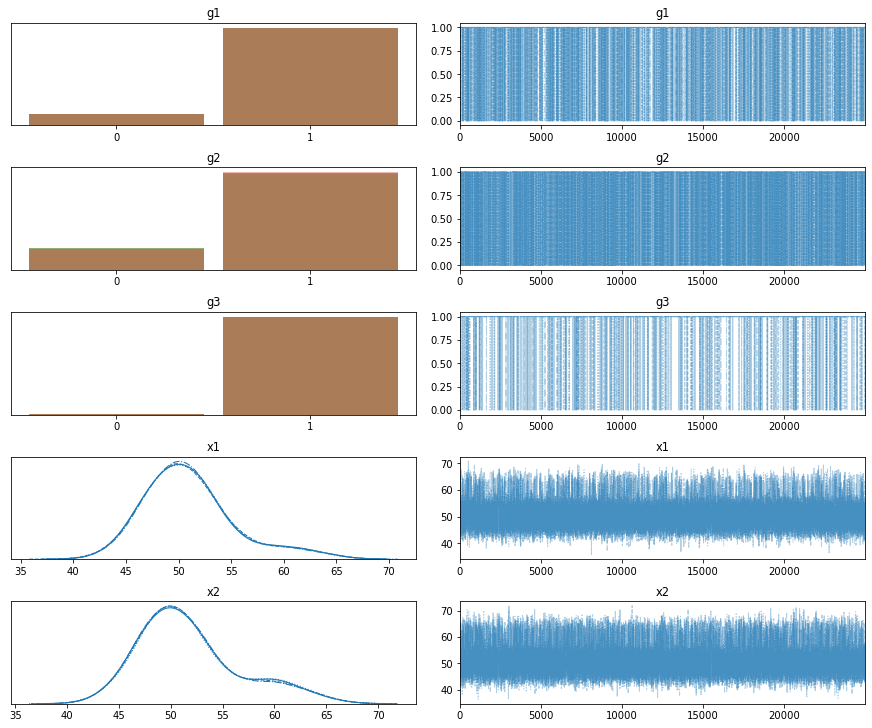

In [22]:
pm.traceplot(mytrace);

In [23]:
df = pm.trace_to_dataframe(mytrace)

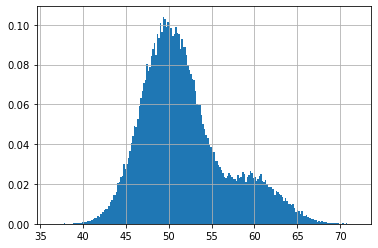

In [24]:
df.x2.hist(bins=200,density=True)

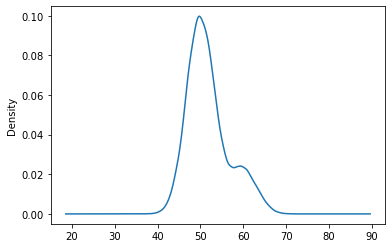

In [25]:
df.x2.plot.kde()

Since we've fixed **$X_3$**, we don't see it in the plots, but we do get the **$X_2$** variable that was previously omitted when it was fixed. We can see that the probability for **$X_2$**= 50 is close to our analytic solution, and we don't have to decide a width, but:

- We still don't have an error estimate on the parameter
- We're just eyeballing a value off of a graph. There's surely a more numerically precise way to do this...

## Estimating a numerically robust solution

My preferred solution is to estimate an empirical PDF (Probability Density Function)  via KDE (Kernel Density Estimation) using the trace of **$X_2$** as the input. This allows probability estimation of any value, including decimal values:

In [26]:
from scipy.stats.kde import gaussian_kde

In [27]:
my_pdf = gaussian_kde(mytrace['x2'])

In [28]:
my_pdf(50)

array([0.0993562])

This treats the continuous variable as continuous, so there is no need to decide an integration width. It is also numerically precise. For error bounds, we can still get them from the trace summary (using the **$X_2$** `mc_error`):

In [29]:
pm.summary(mytrace, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
g1,0.89295,0.30918,0.00000,1.00000,0.00462,0.00327,4483.95961,4483.95961,4483.95961,4483.95961,1.00115
g2,0.81676,0.38687,0.00000,1.00000,0.00544,0.00385,5049.30271,5049.30271,5049.30271,5049.30271,1.00124
g3,0.99392,0.07774,1.00000,1.00000,0.00036,0.00025,47276.25733,47276.25733,47276.25733,100000.00000,1.00011
x1,51.05178,4.45846,43.07390,60.54717,0.04947,0.03615,8123.45579,7604.31723,11322.61518,9199.64749,1.00057
x2,51.81545,5.01304,43.96591,62.72505,0.05797,0.04186,7478.73697,7170.70625,9879.42560,17888.31410,1.00074


This works because we have a numerically precise value of the probability, so we can port the error estimates over. We couldn't do this using the first window method because we were looking over a range interval, and didn't have a precise estimate when looking at just the trace graphs.


Another thing to note-- because statistics are built of an empirically sampled distribution that is rendered via simulation, we are able to retrieve answers from distributions that are not classic well behaved Gaussian's. The distributions **$X_1, X_2,$** and **$X_3$** are not well behaved; they cannot be approximated by a Gaussian, and it's unclear if they could be even be modeled by a combination of classical statical functions. But, using MCMC estimation, we fundamentally don't care what the output distribution looks like; we can query the trace for probability information regardless of it's form. As more explicit example:

In [30]:
# We'll complicate our sampling by adding in more data
# pymc3 allows observed variables to be numpy arrays, pandas
# dataframes, or theano data structures; so you can add
# quite a bit of empirical data

In [31]:
data_1 = [38,58,62,55,80,40,51,52]
data_2 = [32,110,72,43,66,55,59,52]

In [32]:
with Model() as bayesnet:
    # Parent
    g1_healthy = pm.distributions.discrete.Bernoulli('g1',0.5)
    
    # Latent variable that conditions the children 
    g1_L = switch(g1_healthy > 0.5, 0.9, 0.1)
    
    # Left Child
    g2_healthy = pm.distributions.discrete.Bernoulli('g2', g1_L)
    # Right Child
    g3_healthy = pm.distributions.discrete.Bernoulli('g3', g1_L)
    # Conditional switches for blood pressure mean
    rate1 = switch(g1_healthy > .5, 50, 60)
    rate2 = switch(g2_healthy > .5, 50, 60)
    rate3 = switch(g3_healthy > .5, 50, 60)
    # Grandkids and child
    x1 = Normal('x1', mu=rate1, sd=10**.5)
    x2 = Normal('x2', mu=rate2, sd=10**.5, observed=data_2)
    # Setting x3 as an observed variable
    x3 = Normal('x3', mu=rate3, sd=10**.5, observed=data_1)

In [33]:
with bayesnet:
    mytrace = pm.sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [g1, g2, g3]
>NUTS: [x1]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [01:02<00:00, 350.61draws/s]
/srv/conda/envs/MLenv/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
The number of effective samples is smaller than 10% for some parameters.


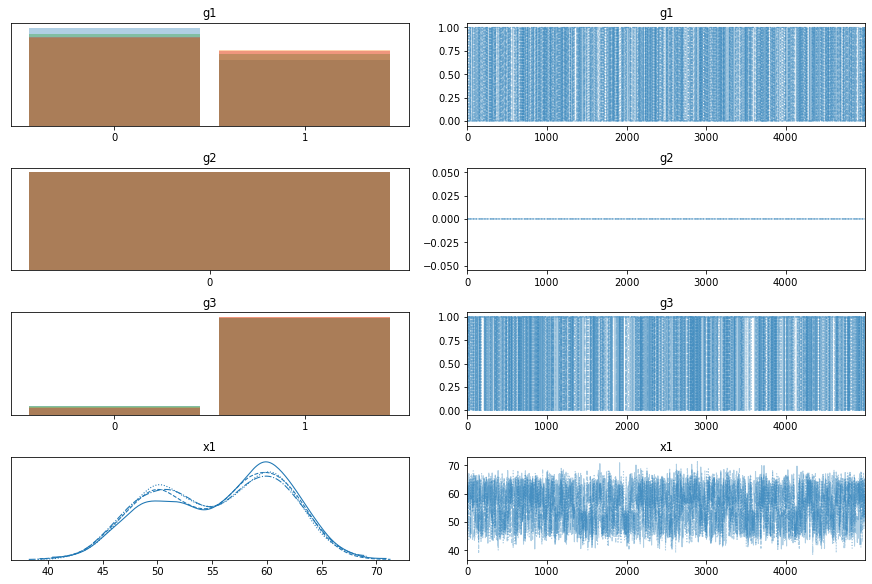

In [34]:
pm.traceplot(mytrace);

Above tells us that the Bayesian estimate is certain that one child has the condition, and is fairly certain that the other doesn't. This means that the parent is more likely to have the condition than not; also note that the blood pressure likelihoods are highest for each case associated with the condition (compared to a mean).